# Project Title:

## Libraries and settings

In [3]:
# Load Python libraries
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Show current working directory
print(os.getcwd())

/workspaces/ARM_Gruppe-5


## Import data

In [4]:
## Read data
df = pd.read_csv("./data/ARM_Master_Table.csv", sep=",")
df.head()

,jahr,bfs_nummer,gemeinde,ds10060_1_person,ds10060_2_personen,ds10060_3_personen,ds10060_4_personen,ds10060_5_personen,ds10060_6_oder_mehr_personen,ds10080_ausland,...,ds13010_3,ds13010_4,ds13010_5plus,ds13010_total,ds13030_andere_situation_unbekannt,ds13030_genossenschafter_innen,ds13030_hauseigentuemer_innen,ds13030_mieter_innen_oder_untermieter_innen,ds13030_stockwerk_wohnungseigentuemer_innen,ds13030_total
0,2010,2841,Anwil,0.0,0.0,0.0,0.0,0.0,0.0,41.0,...,0.0,1464.365875,0.0,1454.050213,25.830483,0.0,103.189222,40.077544,0.0,174.76878
1,2011,2841,Anwil,0.0,0.0,0.0,0.0,0.0,0.0,40.0,...,0.0,1464.365875,0.0,1454.050213,25.830483,0.0,103.189222,40.077544,0.0,174.76878
2,2012,2841,Anwil,37.0,74.0,30.0,49.0,12.0,7.0,43.0,...,0.0,1464.365875,0.0,1454.050213,25.830483,0.0,103.189222,40.077544,0.0,174.76878
3,2013,2841,Anwil,43.0,74.0,35.0,48.0,11.0,6.0,41.0,...,0.0,1464.365875,0.0,1454.050213,25.830483,0.0,103.189222,40.077544,0.0,174.76878
4,2014,2841,Anwil,42.0,74.0,33.0,50.0,12.0,4.0,42.0,...,0.0,1464.365875,0.0,1454.050213,25.830483,0.0,103.189222,40.077544,0.0,174.76878


## Regression model - Quadratmeterpreis Wohnbauland / Bewohner

Regressionsmodell:
Achsenabschnitt (Intercept): 586.66
Steigung (Koeffizient): 0.0140
R²: 0.4146
Anzahl Beobachtungen: 74


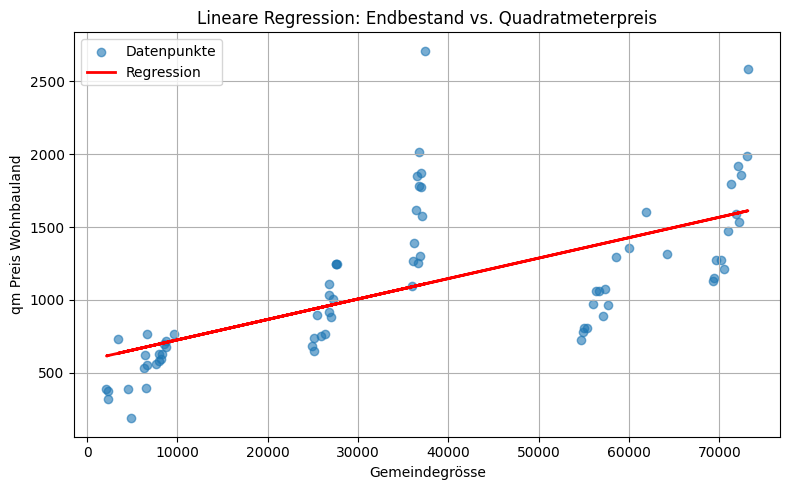

In [16]:
# ----------------------------------------
# Regressionsmodell: Quadratmeterpreis vs. Endbestand
# ----------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ----------------------------------------
# 1. Daten laden
# ----------------------------------------
file_path = "./data/ARM_Master_Table.csv"
df = pd.read_csv(file_path)

# ----------------------------------------
# 2. Relevante Spalten auswählen
# ----------------------------------------
cols = [
    "ds10200_quadratmeterpreis_chf",
    "ds10680_endbestand"
]

df_model = df[cols].copy()

# ----------------------------------------
# 3. Daten bereinigen
#    - NaN entfernen
#    - Werte = 0 entfernen
# ----------------------------------------
df_model = df_model.dropna()
df_model = df_model[
    (df_model["ds10200_quadratmeterpreis_chf"] != 0) &
    (df_model["ds10680_endbestand"] != 0)
]

# ----------------------------------------
# 4. Regressionsvariablen definieren
# ----------------------------------------
X = df_model[["ds10680_endbestand"]]   # unabhängige Variable
y = df_model["ds10200_quadratmeterpreis_chf"]  # abhängige Variable

# ----------------------------------------
# 5. Lineares Regressionsmodell
# ----------------------------------------
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

# ----------------------------------------
# 6. Ergebnisse ausgeben
# ----------------------------------------
print("Regressionsmodell:")
print(f"Achsenabschnitt (Intercept): {model.intercept_:.2f}")
print(f"Steigung (Koeffizient): {model.coef_[0]:.4f}")
print(f"R²: {r2_score(y, y_pred):.4f}")
print(f"Anzahl Beobachtungen: {len(df_model)}")

# ----------------------------------------
# 7. Visualisierung
# ----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.6, label="Datenpunkte")
plt.plot(X, y_pred, color="red", linewidth=2, label="Regression")
plt.xlabel("Gemeindegrösse")
plt.ylabel("qm Preis Wohnbauland")
plt.title("Lineare Regression: Endbestand vs. Quadratmeterpreis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Regression model - Quadratmeterpreis Wohnbauland / Bewohner 2022

Regressionsmodell:
Achsenabschnitt (Intercept): 405.46
Steigung (Koeffizient): 0.0205
R²: 0.9477
Anzahl Beobachtungen: 5


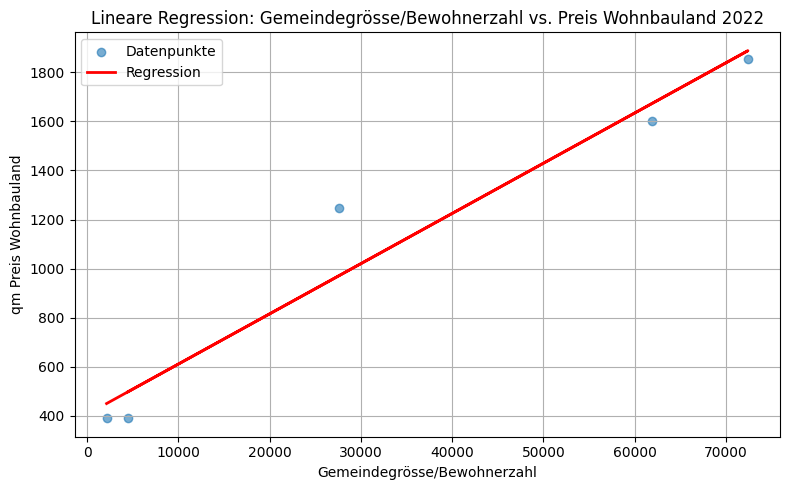

In [5]:
# ----------------------------------------
# Regressionsmodell: Quadratmeterpreis vs. Endbestand
# ----------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ----------------------------------------
# 1. Daten laden
# ----------------------------------------
file_path = "./data/ARM_Master_Table.csv"
df = pd.read_csv(file_path)

# ----------------------------------------
# 1a. Nur Daten aus dem Jahr 2019 verwenden
# ----------------------------------------
df = df[df["jahr"] == 2022]

# ----------------------------------------
# 2. Relevante Spalten auswählen
# ----------------------------------------
cols = [
    "ds10200_quadratmeterpreis_chf",
    "ds10680_endbestand"
]

df_model = df[cols].copy()

# ----------------------------------------
# 3. Daten bereinigen
#    - NaN entfernen
#    - Werte = 0 entfernen
# ----------------------------------------
df_model = df_model.dropna()
df_model = df_model[
    (df_model["ds10200_quadratmeterpreis_chf"] != 0) &
    (df_model["ds10680_endbestand"] != 0)
]

# ----------------------------------------
# 4. Regressionsvariablen definieren
# ----------------------------------------
X = df_model[["ds10680_endbestand"]]   # unabhängige Variable
y = df_model["ds10200_quadratmeterpreis_chf"]  # abhängige Variable

# ----------------------------------------
# 5. Lineares Regressionsmodell
# ----------------------------------------
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

# ----------------------------------------
# 6. Ergebnisse ausgeben
# ----------------------------------------
print("Regressionsmodell:")
print(f"Achsenabschnitt (Intercept): {model.intercept_:.2f}")
print(f"Steigung (Koeffizient): {model.coef_[0]:.4f}")
print(f"R²: {r2_score(y, y_pred):.4f}")
print(f"Anzahl Beobachtungen: {len(df_model)}")

# ----------------------------------------
# 7. Visualisierung
# ----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.6, label="Datenpunkte")
plt.plot(X, y_pred, color="red", linewidth=2, label="Regression")
plt.xlabel("Gemeindegrösse/Bewohnerzahl")
plt.ylabel("qm Preis Wohnbauland")
plt.title("Lineare Regression: Gemeindegrösse/Bewohnerzahl vs. Preis Wohnbauland 2022")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Regression model - Quadratmeterpreis Wohnbauland / Steuerfuss (natürliche Person)

Regressionsmodell:
Achsenabschnitt (Intercept): 4751.95
Steigung (Koeffizient): -59.4496
R²: 0.2464
Anzahl Beobachtungen: 5


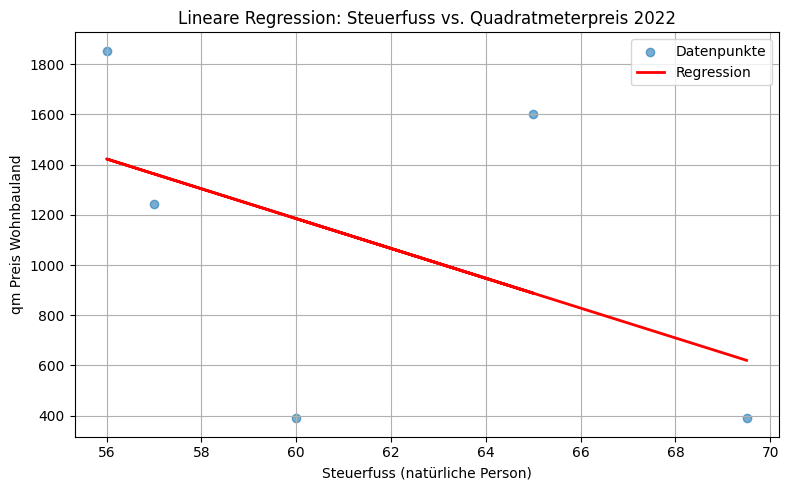

In [4]:
# ----------------------------------------
# Regressionsmodell: Quadratmeterpreis vs. Steuerfuss
# ----------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ----------------------------------------
# 1. Daten laden
# ----------------------------------------
file_path = "./data/ARM_Master_Table.csv"
df = pd.read_csv(file_path)

# ----------------------------------------
# 1a. Nur Daten aus dem Jahr 2019 verwenden
# ----------------------------------------
df = df[df["jahr"] == 2022]

# ----------------------------------------
# 2. Relevante Spalten auswählen
# ----------------------------------------
cols = [
    "ds10200_quadratmeterpreis_chf",
    "ds10580_steuerfuss_natuerliche_personen_prozent"
]

df_model = df[cols].copy()

# ----------------------------------------
# 3. Daten bereinigen
#    - NaN entfernen
#    - Werte = 0 entfernen
# ----------------------------------------
df_model = df_model.dropna()
df_model = df_model[
    (df_model["ds10200_quadratmeterpreis_chf"] != 0) &
    (df_model["ds10580_steuerfuss_natuerliche_personen_prozent"] != 0)
]

# ----------------------------------------
# 4. Regressionsvariablen definieren
# ----------------------------------------
X = df_model[["ds10580_steuerfuss_natuerliche_personen_prozent"]]   # unabhängige Variable
y = df_model["ds10200_quadratmeterpreis_chf"]  # abhängige Variable

# ----------------------------------------
# 5. Lineares Regressionsmodell
# ----------------------------------------
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

# ----------------------------------------
# 6. Ergebnisse ausgeben
# ----------------------------------------
print("Regressionsmodell:")
print(f"Achsenabschnitt (Intercept): {model.intercept_:.2f}")
print(f"Steigung (Koeffizient): {model.coef_[0]:.4f}")
print(f"R²: {r2_score(y, y_pred):.4f}")
print(f"Anzahl Beobachtungen: {len(df_model)}")

# ----------------------------------------
# 7. Visualisierung
# ----------------------------------------
plt.figure(figsize=(8, 5))
plt.scatter(X, y, alpha=0.6, label="Datenpunkte")
plt.plot(X, y_pred, color="red", linewidth=2, label="Regression")
plt.xlabel("Steuerfuss (natürliche Person)")
plt.ylabel("qm Preis Wohnbauland")
plt.title("Lineare Regression: Steuerfuss vs. Quadratmeterpreis 2022")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()